In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 2.6MB/s 
     |████████████████████████████████| 92kB 29.4MB/s 
     |████████████████████████████████| 655kB 38.2MB/s 
  Created wheel for regex: filename=regex-2019.8.19-cp36-cp36m-linux_x86_64.whl size=609243 sha256=dbc29d4432d58414569414e0eba00de1092cf151bd645fd5d11240c3877c8e3d
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
Successfully built regex


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [4]:
pip install gpu-utils

     |████████████████████████████████| 440kB 8.3MB/s 
  Created wheel for colored: filename=colored-1.3.93-cp36-none-any.whl size=12575 sha256=ff0edb92ed0e78d083744176fe44825af7a14d0819fb2cf1abb261af2fe0281e
  Stored in directory: /root/.cache/pip/wheels/52/c3/b7/ac21460710230feb409fee89bf594c4f2660ff7b67491d128f
  Created wheel for psutil: filename=psutil-5.6.3-cp36-cp36m-linux_x86_64.whl size=274716 sha256=560165ec33bed96c1e5ae6b13f0cc2189bb50cbb9a251d572d9b99b838eb449b
  Stored in directory: /root/.cache/pip/wheels/90/7e/74/bb640d77775e6b6a78bcc3120f9fea4d2a28b2706de1cff37d
Successfully built colored psutil
  Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [5]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device(device_ef())
#device= eff_gpu()
from gpu_utils import gpu_init
device = gpu_init(ml_library="torch")


n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [8]:
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()

Saving training_score_labels.csv to training_score_labels.csv


In [0]:
df = pd.read_csv("training_score_labels.csv",encoding='latin-1')

In [10]:
df.shape

(12976, 6)

In [11]:
df.sample(10)

,Unnamed: 0,essay_id,essay_set,essay,score,labels
7287,7287,12035,5,The mood created by the @CAPS1 in the memoir i...,3,1
130,130,131,1,"Dear @ORGANIZATION1 @CAPS1 @CAPS2, Computers a...",5,2
10807,10807,17971,7,ÃÂTime to go outside!ÃÂthe teacher said ha...,4,1
9266,9266,15216,6,The builders of the Empire State building face...,5,2
9116,9116,15066,6,The builders of the empire state building face...,5,2
5988,5988,9544,4,He is referring to the lifestyle of Saeng and ...,0,0
8420,8420,13168,5,The mood created by @ORGANIZATION1 in the memo...,3,1
6460,6460,10017,4,The author concludes the story with that parag...,0,0
11444,11444,18685,7,Im @PERSON1 and a year ago I was a foster kid....,5,2
10636,10636,16586,6,The builders of the Empire State building face...,6,2


In [12]:
sentences = df.essay.values

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.labels.values
print(sentences[0])
print(labels[0])

[CLS] Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the e

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 416611.93B/s]


Tokenize the first sentence:
['[CLS]', 'dear', 'local', 'newspaper', ',', 'i', 'think', 'effects', 'computers', 'have', 'on', 'people', 'are', 'great', 'learning', 'skills', '/', 'affects', 'because', 'they', 'give', 'us', 'time', 'to', 'chat', 'with', 'friends', '/', 'new', 'people', ',', 'helps', 'us', 'learn', 'about', 'the', 'globe', '(', 'astronomy', ')', 'and', 'keeps', 'us', 'out', 'of', 'tr', '##ob', '##le', '!', 'thing', 'about', '!', 'don', '##t', 'you', 'think', 'so', '?', 'how', 'would', 'you', 'feel', 'if', 'your', 'teenager', 'is', 'always', 'on', 'the', 'phone', 'with', 'friends', '!', 'do', 'you', 'ever', 'time', 'to', 'chat', 'with', 'your', 'friends', 'or', 'bu', '##is', '##ness', 'partner', 'about', 'things', '.', 'well', 'now', '-', 'there', "'", 's', 'a', 'new', 'way', 'to', 'chat', 'the', 'computer', ',', 'theirs', 'plenty', 'of', 'sites', 'on', 'the', 'internet', 'to', 'do', 'so', ':', '@', 'organization', '##1', ',', '@', 'organization', '##2', ',', '@', 'caps',

In [0]:
MAX_LEN = 128

In [15]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (723 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (562 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (607 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (539 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (622 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length f

In [0]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
batch_size = 32


train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [22]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.cuda()

100%|██████████| 407873900/407873900 [00:36<00:00, 11144949.22B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediat

In [0]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [24]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:

train_loss_set = []

epochs = 4

for _ in trange(epochs, desc="Epoch"):
  
  
  model.train()
  
  
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  
  for step, batch in enumerate(train_dataloader):
    
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    
    optimizer.zero_grad()
    
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    
    loss.backward()
    
    optimizer.step()
    
    
    
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
 model.eval()

   
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  
  for batch in validation_dataloader:
    
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.7498186766999225


Epoch:  25%|██▌       | 1/4 [13:40<41:00, 820.16s/it]

Validation Accuracy: 0.713957055214724
Train loss: 0.6135857517792754


Epoch:  50%|█████     | 2/4 [27:21<27:20, 820.48s/it]

Validation Accuracy: 0.7124233128834356
Train loss: 0.48971230794407733


Epoch:  75%|███████▌  | 3/4 [41:04<13:41, 821.24s/it]

Validation Accuracy: 0.7200920245398773
Train loss: 0.3299035197302495


Epoch: 100%|██████████| 4/4 [54:48<00:00, 822.05s/it]

Validation Accuracy: 0.7116564417177914


In [0]:
torch.save(model.state_dict(), './model.pth')

In [80]:
from google.colab import files
files.download('model.pth') 

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 53936, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

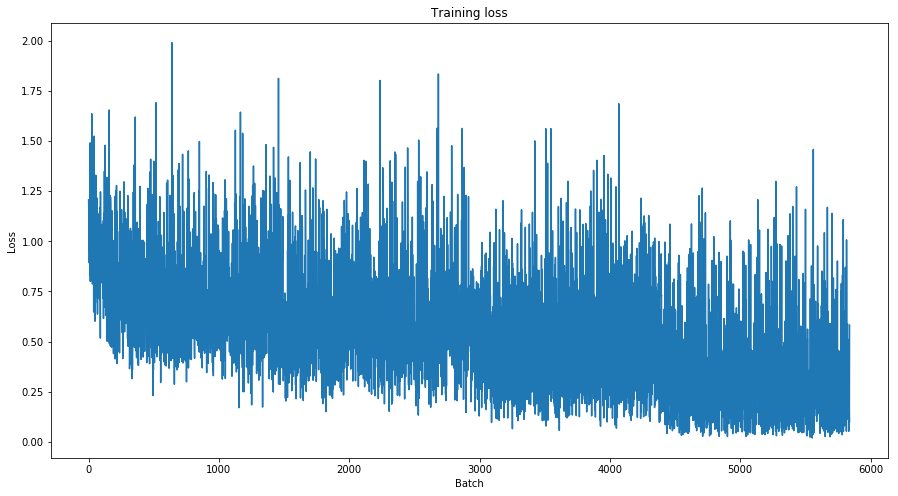

In [27]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [28]:
from google.colab import files
uploaded = files.upload()


Saving test.csv to test.csv


In [0]:
df = pd.read_csv("test.csv",encoding='latin-1')
sentences = df.essay.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [0]:
df = pd.read_csv("test.csv",encoding='latin-1')


sentences = df.essay.values


sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128


input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []


for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
model.eval()

 
predictions , true_labels = [], []


for batch in prediction_dataloader:
  
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [62]:
pred_class=[]
for i in range(len(true_labels)):
   pred_class.append(np.argmax(predictions[i],axis=1))
print(pred_class)    

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       2])]


In [36]:
matthews_set

[0.6282808624375432]

In [0]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [38]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.6282808624375432

In [0]:
y_actu_1 = [2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2]
y_pred_1 = [0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2]

In [56]:
print(y_actu_1)

[2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2]
